# Embeddings training

**Required files:**
 - event_df_clean = event specific dataframe with preprocessed text, use column 'text_coherent' for training
 - event_cands_merged = dataframe of candidates that are merged after 1st step


Import relevant packages for the following parts

In [1]:
#python libraries
import numpy as np
import pandas as pd
import os
import re
import gensim

import time
from tqdm import tqdm

from collections import Counter, defaultdict

# self written modules
import preprocessing

# storing python objects in the desired locations using pickle
import pickle

def pickle_file(file_name, file_to_dump):
    directory_path = os.getcwd() + "/../../../../"
    folder_name = file_name.split('_')[0]
    file_path = directory_path +  fr"Dropbox (CBS)/Master thesis data/Candidate Data/{folder_name}/{file_name}"
    with open(file_path, 'wb') as fp:
        pickle.dump(file_to_dump, fp)

def load_pickle(file_name):
    directory_path = os.getcwd() + "/../../../../"
    folder_name = file_name.split('_')[0]
    file_path = directory_path + fr"Dropbox (CBS)/Master thesis data/Candidate Data/{folder_name}/{file_name}"
    with open(file_path, "rb") as input_file:
        return pickle.load(input_file)


Reading english - 1grams ...
Reading english - 1grams ...
Reading english - 2grams ...


C:\ProgramData\Anaconda3\lib\site-packages\ekphrasis\classes\exmanager.py:14: FutureWarning: Possible nested set at position 42
  regexes = {k.lower(): re.compile(self.expressions[k]) for k, v in


## 1. Import the data

In [3]:
tigray_url = r"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_tigray_clean.csv" # location of Tigray dataset
greece_url = r"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_greece_clean.csv" # location of Greece dataset
rohingya_url = r"Dropbox (CBS)/Master thesis data/Event Dataframes/Clean/df_rohingya_clean.csv" # location of Rohingya dataset
all_url = r"Dropbox (CBS)/Master thesis data/df_tweets.csv" # for all tweets

def read_event_df(data_url):
    directory_path = os.getcwd() + "/../../../../" + data_url 
    event_df = pd.read_csv(directory_path, index_col=0)
    event_df.reset_index(drop=True, inplace=True)
    print(f'loaded {event_df.shape[0]} tweets!')
    return event_df

# pick the df 
event_df = read_event_df(greece_url)


loaded 137462 tweets!


## BERT embeddings

In [5]:
from nltk.tokenize import sent_tokenize

def train_embeddings(tweet_sentences, event_cands):
    from time import time
    from sentence_transformers import SentenceTransformer
    sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

    bert_corpus = tweet_sentences + list(event_cands['cand_text'])

    print(f'there are {len(bert_corpus)} sentences to be encoded')
    t0 = time()
    cands_embeddings = sbert_model.encode(bert_corpus)
    print(f'Training embeddings took {time()-t0} seconds')
    return cands_embeddings

In [6]:
event_df = read_event_df(tigray_url)
unique_tweets_df = preprocessing.fuzzy_duplicate_removal(event_df)
tweet_sentences = [sent for tweet in unique_tweets_df['text_alphanum'] for sent in sent_tokenize(tweet)]
event_cands = load_pickle('tigray_cands_after1')

document_embeddings = train_embeddings(tweet_sentences, event_cands)

pickle_file('tigray_bert_embeddings_sents', document_embeddings[len(tweet_sentences):])

loaded 42853 tweets!
Tweets at the start: 42853
Tweets after 100% duplicates removed: 42164
calculating similarities across documents...


3483it [00:00, 34499.46it/s]

Similarity calculation completed in 152.17315030097961 seconds
removing fuzzy duplicates...


112872it [00:03, 37338.31it/s]
C:\Users\nikodemicek\Documents\GitHub\refugee_project\Code\preprocessing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dupl_removed['is_dup'][i] = True


32831 tweets left after 70.0% similar tweets (by cosine similarity) removed
99710
Training embeddings took 5537.992118358612 seconds


In [7]:
event_df = read_event_df(rohingya_url)
unique_tweets_df = preprocessing.fuzzy_duplicate_removal(event_df)
tweet_sentences = [sent for tweet in unique_tweets_df['text_alphanum'] for sent in sent_tokenize(tweet)]
event_cands = load_pickle('rohingya_cands_after1')

document_embeddings = train_embeddings(tweet_sentences, event_cands)

pickle_file('rohingya_bert_embeddings_sents', document_embeddings[len(tweet_sentences):])

loaded 29432 tweets!
Tweets at the start: 29432
Tweets after 100% duplicates removed: 28820
calculating similarities across documents...


7411it [00:00, 37273.21it/s]

Similarity calculation completed in 50.258936405181885 seconds
removing fuzzy duplicates...


90075it [00:02, 37421.54it/s]
C:\Users\nikodemicek\Documents\GitHub\refugee_project\Code\preprocessing.py:90: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dupl_removed['is_dup'][i] = True


21154 tweets left after 70.0% similar tweets (by cosine similarity) removed
62107
Training embeddings took 3018.543573617935 seconds


In [ ]:
event_df = read_event_df(channel_url)
unique_tweets_df = preprocessing.fuzzy_duplicate_removal(event_df)
tweet_sentences = [sent for tweet in unique_tweets_df['text_alphanum'] for sent in sent_tokenize(tweet)]
event_cands = load_pickle('channel_cands_after1')

document_embeddings = train_embeddings(tweet_sentences, event_cands)

pickle_file('channel_bert_embeddings_sents', document_embeddings[len(tweet_sentences):])

## Create dataframe with similarities

In [10]:
from sklearn.metrics.pairwise import cosine_similarity

def create_sim_df(cand_df,cand_embeddings,sim_threshold=0.7):

    rows_list = []
    for up_cand_id in tqdm(range(len(event_cands))):
        for low_cand_id in range(up_cand_id+1,len(event_cands)):
            sim = cosine_similarity(
                cand_embeddings[up_cand_id].reshape(1,-1),
                cand_embeddings[low_cand_id].reshape(1,-1)
            )
            dict1 = {}
            # get input row in dictionary format
            # key = col_name
            if sim>sim_threshold:
                dict1.update({'text': event_cands['cand_text'][up_cand_id], 'text_to_compare':event_cands['cand_text'][low_cand_id], 'sim':sim[0][0]}) 
                rows_list.append(dict1)

    sim_df = pd.DataFrame(rows_list)
    return sim_df

In [ ]:
event_cands = load_pickle('rohingya_cands_after1')
cand_embeddings = load_pickle('rohingya_bert_embeddings')

sim_df = create_sim_df(event_cands,cand_embeddings)
pickle_file('rohingya_sim_df',sim_df)

  7%|█████▌                                                                      | 929/12738 [43:36<8:35:36,  2.62s/it]

In [ ]:
event_cands = load_pickle('tigray_cands_after1')
cand_embeddings = load_pickle('tigray_bert_embeddings')

sim_df = create_sim_df(event_cands,cand_embeddings)
pickle_file('tigray_sim_df',sim_df)

In [ ]:
event_cands = load_pickle('greece_cands_after1')
cand_embeddings = load_pickle('greece_bert_embeddings')

sim_df = create_sim_df(event_cands,cand_embeddings)
pickle_file('greece_sim_df',sim_df)

In [ ]:
event_cands = load_pickle('channel_cands_after1')
cand_embeddings = load_pickle('channel_bert_embeddings')

sim_df = create_sim_df(event_cands,cand_embeddings)
pickle_file('channel_sim_df',sim_df)

## Train embeddings for topic modeling


In [5]:
# train this model only after the first merging step to save both memory and time
words_to_cluster =  ["accept" ,        "ally"     ,      "army"     ,      "attack"     ,    "attacking"  ,    "authority"   ,   "benefit"       
,"billion"    ,    "blackmail"    ,  "block"   ,       "boat"    ,       "bomb"     ,      "bombing"  ,      "border"        
,"break"       ,   "build"   ,       "burden"    ,     "camp" ,          "care"      ,     "child",          "citizen"       
,"city"       ,    "civil"    ,      "civilian" ,      "clash" ,         "closed"         ,"coast" ,         "community"     
,"conflict"  ,     "control"   ,     "creating",       "crime"  ,        "criminal"      , "cross"  ,        "crossing"      
,"dead"     ,      "death"      ,    "defend" ,        "desperate",      "dictator"     ,  "displaced",      "door"          
,"economic",       "economy"     ,   "entering"       ,"entry"     ,     "family"      ,   "fear"      ,     "fence"         
,"fight"          ,"fighting"     ,  "fire"          , "fled"       ,    "flee"       ,    "fleeing"    ,    "flood"         
, "flow"         ,  "food"         ,  "force"       ,   "forced"     ,    "foreign"  ,      "friend"     ,    "game"          
 ,"gate"        ,   "government"    , "guard"      ,    "health"      ,   "help"    ,       "helping"     ,   "history"       
, "hold"       ,    "hope"           ,"host"      ,     "hosting"      ,  "house"  ,        "human"        ,  "humanitarian"  
,"humanity"   ,    "hundred"  ,      "illegal"   ,     "illegally"      ,"influx" ,        "innocent"       ,"invade"        
, "invader"  ,      "invading" ,      "invasion",       "islamic"        ,"jihadist"      , "kid" ,           "kill"          
,"killed"   ,      "killing"    ,    "leaving" ,       "legal"   ,       "march"         , "mass"  ,         "military"      
, "million"       , "minister"   ,    "money"         , "movement",       "national"    ,   "number",         "official"      
, "opening"      ,  "order"       ,   "peace"        ,  "picture"  ,      "police"     ,    "policy" ,        "population"    
, "power"       ,   "pressure"     ,  "prevent"     ,   "protect"   ,     "protection",     "pushing" ,       "refuge"        
,"regime"      ,   "region"         ,"respect"     ,   "responsibility", "return"    ,     "risk"      ,     "rule"          
,"safety"     ,    "school"    ,     "security"   ,    "shelter" ,       "shooting" ,      "shot"       ,    "social"        
,"soldier"      ,  "solidarity" ,    "solution"  ,     "suffering",      "support" ,       "supporting"  ,   "tension"       
, "territory"  ,    "terrorist"  ,    "thousand",       "threat"   ,      "travel",         "troop"       ,   "violence"      
, "war"       ,     "wave"        ,   "weapon" ,        "woman"     ,     "work" ,          "worker"       ,  "working"       
, "zone"]

print(unique_tweets_df['text_alphanum'].shape)
len(words_to_cluster)

(116533,)


155

In [6]:
from nltk.tokenize import sent_tokenize

tweet_sentences = [sent for tweet in unique_tweets_df['text_alphanum'] for sent in sent_tokenize(tweet)]
len(tweet_sentences)

304618

In [7]:
from time import time
from sentence_transformers import SentenceTransformer
sbert_model = SentenceTransformer('bert-base-nli-mean-tokens')

bert_corpus = tweet_sentences + words_to_cluster

print(len(bert_corpus))
t0 = time()
document_embeddings = sbert_model.encode(bert_corpus)
print(f'Training embeddings took {time()-t0} seconds')

304773
Training embeddings took 14255.078019618988 seconds


In [8]:
words_embeddings = document_embeddings[len(tweet_sentences):]
len(words_embeddings)

155

In [9]:
pickle_file('greece_frame_devices',words_embeddings)

## Factor analysis

In [10]:
vector_dict =dict()
for word,vector in zip(words_to_cluster,words_embeddings):
    vector_dict[word] = vector
    
vector_df = pd.DataFrame.from_dict(vector_dict)

In [11]:
from factor_analyzer.factor_analyzer import calculate_kmo
kmo_all,kmo_model=calculate_kmo(vector_df)
kmo_model

C:\ProgramData\Anaconda3\lib\site-packages\factor_analyzer\utils.py:248: UserWarning: The inverse of the variance-covariance matrix was calculated using the Moore-Penrose generalized matrix inversion, due to its determinant being at or very close to zero.
  warnings.warn('The inverse of the variance-covariance matrix '


0.9797106085627821

In [12]:
from factor_analyzer import FactorAnalyzer
# Create factor analysis object and perform factor analysis
fa = FactorAnalyzer()
fa.fit(vector_df)
eigen_values, vectors = fa.get_eigenvalues()
ev, v = fa.get_eigenvalues()
ev

array([9.35845322e+01, 1.01590584e+01, 4.91456477e+00, 3.60466784e+00,
       2.67291602e+00, 2.58951673e+00, 2.33929185e+00, 2.20172897e+00,
       1.92165318e+00, 1.78889966e+00, 1.68665122e+00, 1.39208245e+00,
       1.33429308e+00, 1.19369116e+00, 1.09177940e+00, 1.00336083e+00,
       9.44505569e-01, 8.88251063e-01, 8.43346851e-01, 8.10440547e-01,
       7.47206429e-01, 7.08117471e-01, 6.78283896e-01, 6.02021651e-01,
       5.79650420e-01, 5.51110672e-01, 5.27730353e-01, 4.83445174e-01,
       4.59648707e-01, 4.51691972e-01, 4.24161474e-01, 4.15062056e-01,
       3.97642616e-01, 3.80658451e-01, 3.57839758e-01, 3.46085035e-01,
       3.42153311e-01, 3.28989453e-01, 3.11042595e-01, 3.01548525e-01,
       2.91432236e-01, 2.88063399e-01, 2.72740037e-01, 2.57723586e-01,
       2.51922934e-01, 2.48646126e-01, 2.36164531e-01, 2.22485808e-01,
       2.19815345e-01, 2.11220912e-01, 2.07586190e-01, 1.95047149e-01,
       1.87533448e-01, 1.79569742e-01, 1.70928733e-01, 1.62450591e-01,
      

In [62]:
fa = FactorAnalyzer(8,rotation='varimax')
fa.fit(vector_df)
fa.loadings_

array([[ 0.77589529,  0.15274744,  0.42710425, ..., -0.06760842,
         0.01822708,  0.03108136],
       [ 0.62693226,  0.26928761,  0.39813795, ...,  0.05882632,
         0.04679468, -0.11214675],
       [ 0.28046608,  0.39202815,  0.63023891, ...,  0.18727929,
        -0.04265644, -0.1598941 ],
       ...,
       [ 0.49701253,  0.33157154,  0.40999486, ...,  0.36964628,
         0.05635212,  0.06435311],
       [ 0.60669317,  0.31072967,  0.46535337, ...,  0.19473432,
         0.13874666,  0.14098394],
       [ 0.48774794,  0.38194356,  0.55227271, ..., -0.01564182,
         0.10472588,  0.06521249]])

In [63]:
factor_dict =dict()
for word,factor in zip(words_to_cluster,fa.loadings_):
    factor_dict[word] = factor
    
factor_df = pd.DataFrame.from_dict(factor_dict)
factor_df

,accept,ally,army,attack,attacking,authority,benefit,billion,blackmail,block,...,troop,violence,war,wave,weapon,woman,work,worker,working,zone
0,0.775895,0.626932,0.280466,0.184605,0.204254,0.750761,0.842445,0.307236,0.202197,0.301738,...,0.404962,0.167772,0.094106,0.505003,0.496872,0.523589,0.517497,0.497013,0.606693,0.487748
1,0.152747,0.269288,0.392028,0.764439,0.764583,0.285503,0.164447,0.267985,0.765309,0.478337,...,0.292191,0.858763,0.800476,0.303170,0.458673,0.361960,0.336977,0.331572,0.310730,0.381944
2,0.427104,0.398138,0.630239,0.499457,0.483401,0.302461,0.177042,0.402414,0.185857,0.580594,...,0.560824,0.165178,0.294885,0.417850,0.431655,0.302948,0.496113,0.409995,0.465353,0.552273
3,0.193027,0.145349,0.079266,0.060531,-0.047443,0.005562,0.173465,0.148329,0.185127,0.252125,...,0.122426,0.115285,0.176769,0.225282,0.048029,0.166834,0.099257,0.080928,0.067458,0.273569
4,0.242400,0.167045,0.226697,0.173603,0.108253,0.213769,0.151508,0.660464,0.075004,0.265102,...,0.267329,0.022959,0.150049,0.181045,0.092164,0.183143,0.260275,0.222536,0.215704,0.165515
5,-0.067608,0.058826,0.187279,-0.068686,-0.047494,0.144331,0.107739,0.101731,0.182928,0.028579,...,0.220446,0.142785,0.039463,0.047701,0.164062,0.111885,0.201149,0.369646,0.194734,-0.015642
6,0.018227,0.046795,-0.042656,-0.065327,-0.002794,0.204118,-0.027480,0.029357,0.030737,0.119789,...,0.054856,0.085753,-0.037737,0.015181,0.004703,0.058730,0.118139,0.056352,0.138747,0.104726
7,0.031081,-0.112147,-0.159894,0.094061,0.143202,-0.061495,0.107845,-0.035355,0.020267,0.148384,...,0.006888,0.154540,-0.096029,0.273134,0.089285,0.190017,0.104511,0.064353,0.140984,0.065212


In [66]:
factor_df_transposed = factor_df.T 
factor_df_transposed[factor_df_transposed[0]>0.5]

,0,1,2,3,4,5,6,7
accept,0.775895,0.152747,0.427104,0.193027,0.242400,-0.067608,0.018227,0.031081
ally,0.626932,0.269288,0.398138,0.145349,0.167045,0.058826,0.046795,-0.112147
authority,0.750761,0.285503,0.302461,0.005562,0.213769,0.144331,0.204118,-0.061495
benefit,0.842445,0.164447,0.177042,0.173465,0.151508,0.107739,-0.027480,0.107845
care,0.848464,0.246497,0.266871,0.072292,0.082393,0.054231,0.133366,0.070195
child,0.509021,0.316627,0.372693,0.062900,0.017307,0.206943,0.049554,0.298996
citizen,0.539710,0.232185,0.450161,0.102648,0.225476,0.373228,0.018554,-0.068875
civil,0.801424,0.093681,0.201549,0.277338,0.079500,0.111698,0.015138,-0.185173
civilian,0.589642,0.225863,0.152959,0.453347,0.138467,0.282783,-0.018744,-0.084266
coast,0.544918,0.205171,0.541613,0.370948,0.099599,0.017663,0.072340,0.067008


## Clustering frame modeling

In [101]:
from time import time
import umap.umap_ as umap
start = time()
reducer = umap.UMAP(random_state=42,n_components=3)
reduced_embedding = reducer.fit_transform(words_embeddings)
print(f'Duration: {time() - start} seconds')

Duration: 1.5624992847442627 seconds


In [82]:
from sklearn.cluster import DBSCAN
start = time()
cluster_labels = DBSCAN(min_samples=6).fit_predict(reduced_embedding)
print(f'Duration: {time() - start} seconds')


Duration: 0.003983736038208008 seconds


In [102]:
from sklearn.cluster import AffinityPropagation

start = time()
cluster_labels = AffinityPropagation().fit_predict(reduced_embedding)
print(f'Duration: {time() - start} seconds')

Duration: 0.04201984405517578 seconds


C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_affinity_propagation.py:154: FutureWarning: 'random_state' has been introduced in 0.23. It will be set to None starting from 1.0 (renaming of 0.25) which means that results will differ at every function call. Set 'random_state' to None to silence this warning, or to 0 to keep the behavior of versions <0.23.
  FutureWarning


In [24]:
from sklearn.cluster import KMeans
k_clusters = KMeans(n_clusters=8, random_state=42).fit_predict(reduced_embedding)

<AxesSubplot:>

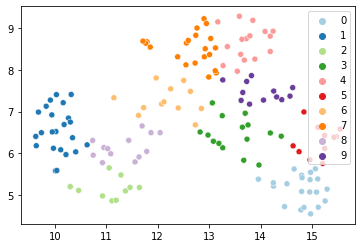

In [89]:
import seaborn

seaborn.scatterplot(x = reducer.embedding_[:, 0],
                y = reducer.embedding_[:, 1],
                hue = cluster_labels, palette ="Paired")

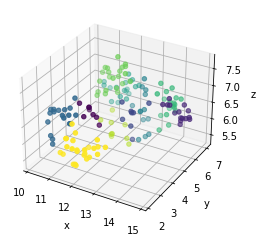

In [103]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

fig = plt.figure()
ax = fig.add_subplot(111, projection = '3d')

x = reducer.embedding_[:, 0]
y = reducer.embedding_[:, 1]
z = reducer.embedding_[:, 2]

ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_zlabel("z")

ax.scatter(x, y, z, c = cluster_labels)

plt.show()

In [128]:
labeled_tweets = pd.DataFrame({'word': words_to_cluster,'label':cluster_labels})

# Create documents per label
docs_per_class = labeled_tweets.groupby(['label'], as_index=False).agg({'word': ' '.join})

words_per_class = dict()
for label,word in zip(docs_per_class['label'],docs_per_class['word']):
    words_per_class[label] = word.split(' ')


   label                                               word
0      0  block burden flood force forced pressure pushi...
1      1  accept authority benefit care civil civilian h...
2      2  child human kid military movement power weapon...
3      3  break closed dead death desperate displaced fe...
4      4  citizen defend economic economy government gua...
5      5  build city creating crossing door entering ent...
6      6  ally camp community family food friend help he...
7      7  boat border coast control cross flow game hist...
8      8  army billion hundred influx march mass million...
9      9  attack attacking blackmail bomb bombing clash ...


In [134]:
pd.DataFrame(dict([ (k,pd.Series(v)) for k,v in words_per_class.items() ])).fillna('.')

,0,1,2,3,4,5,6,7,8,9
0,block,accept,child,break,citizen,build,ally,boat,army,attack
1,burden,authority,human,closed,defend,city,camp,border,billion,attacking
2,flood,benefit,kid,dead,economic,creating,community,coast,hundred,blackmail
3,force,care,military,death,economy,crossing,family,control,influx,bomb
4,forced,civil,movement,desperate,government,door,food,cross,march,bombing
5,pressure,civilian,power,displaced,guard,entering,friend,flow,mass,clash
6,pushing,health,weapon,fear,money,entry,help,game,million,conflict
7,tension,innocent,woman,fled,police,fence,helping,history,population,crime
8,.,legal,.,flee,social,gate,hope,hold,thousand,criminal
9,.,official,.,fleeing,soldier,host,humanitarian,islamic,troop,dictator


In [43]:
from sklearn.metrics import silhouette_score, silhouette_samples
from sklearn.cluster import KMeans, DBSCAN
def kmean_test_n_clusters(data, n_clusters):
    """
    Takes the document vectors and the maximum amount of clusters to look for. 
    Performs KMeans algorithm on the dataset for each amount of clusters. 
    Calculates silhouette score and interias for each amount of clusters. 
    Plots the scores as a function of the amount of clusters.
    
    Arguments: 
    data -- document vectors as numpy matrices
    n_clusters -- integer that determines the maximum amount of clusters to test
    
    Returns: 
    Prints the scores as functions of the clusters in range 1, n_clusters
    """
    n_clusters += 1
    kmeans_per_k = [KMeans(n_clusters=k, random_state=42).fit(data) for k in tqdm(range(1, n_clusters))]
    print("clusters done")
    inertias = [model.inertia_ for model in kmeans_per_k]
    print("inertias done")
    silhouette_scores = [silhouette_score(data, model.labels_)
                         for model in tqdm(kmeans_per_k[1:])]
    print("silhouettes done")

    fig, (ax1, ax2) = plt.subplots(2,1, figsize=(8, 3.5))

    ax1.plot(range(1, n_clusters), inertias, "bo-")
    ax1.set_xlabel("$k$", fontsize=14)
    ax1.set_ylabel("Inertia", fontsize=14)
    #ax1.annotate('Elbow',
    #             xy=(4, inertias[3]),
    #             xytext=(0.55, 0.55),
    #             textcoords='figure fraction',
    #             fontsize=16,
    #             arrowprops=dict(facecolor='black', shrink=0.1)
    #            )
    ax2.plot(range(2, n_clusters), silhouette_scores, "bo-")
    ax2.set_xlabel("$k$", fontsize=14)
    ax2.set_ylabel("Silhouette score", fontsize=14)
    #plt.axis([2, 8, 0.3, 0.475])
    plt.show()


  0%|                                                                                           | 0/30 [00:00<?, ?it/s]C:\ProgramData\Anaconda3\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "

100%|██████████████████████████████████████████████████████████████████████████████████| 30/30 [00:03<00:00,  8.14it/s]

100%|█████████████████████████████████████████████████████████████████████████████████| 29/29 [00:00<00:00, 322.12it/s]


clusters done
inertias done
silhouettes done


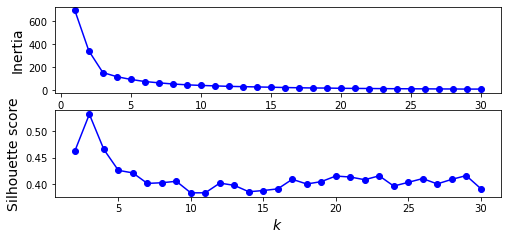

In [47]:
kmean_test_n_clusters(reduced_embedding, 30)